In [1]:
# Import dependecies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt # for visualizing results
%matplotlib inline

In [2]:
# import data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Image size
n_pixels = 28*28

X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [4]:
# Define Weight, Bias, and FC functions

def weight_variables(shape, name):
    # truncated means bounded
    # stddev -> standars deviation
    init = tf.truncated_normal(shape, stddev=0.1)
    # return as variables
    return tf.Variable(init, name=name)

def bias_variables(shape, name):
    # bias increases the flexibility of the model
    init = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init, name=name)

def FC_layer(X, W, b):
    return tf.matmul(X, W) + b    

# Seperating the mean, standard deiviation, and randomness

In the model, we have randomness (stochastic) build in the model. When backpropagating, we will be only doing in respect tothe mean and the standrd deiviation, because they are pre-determined value while randomness is not.

In [5]:
# Encoder

# latent means to represent something that cannot be seen
latent_dim = 20

# number of neurons in the hidden layer
n_neurons = 500

# layer 1
W_enc = weight_variables([n_pixels, n_neurons], "W_enc")
b_enc = bias_variables([n_neurons], "b_enc")

# tanh - activation function
# sigmoid > 0 to 1
# tanh > -1 to 1
# When it comes to generative models, tanh is more efective in avoding
# the fanashing gradient problem instead of sigmoids
h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

# Layer 2

# Mean output
W_m = weight_variables([n_neurons, latent_dim], "W_m")
b_m = bias_variables([latent_dim], "b_m")
m = FC_layer(h_enc, W_m, b_m)

# Standard Deviation
W_logstd = weight_variables([n_neurons, latent_dim], "W_logstd")
b_logstd = bias_variables([latent_dim], "b_logstd")
logstd = FC_layer(h_enc, W_logstd, b_logstd)


# Randomness
# While the randomness is not affected by back propogation, it helps genrate th output z.
# The great thing about noise, it adds randomness to the output without affecting
# backpropagation.
noise = tf.random_normal([1, latent_dim])

# Wee will feed z into our decoder
z = m + tf.multiply(noise, tf.exp(.5*logstd))

In [6]:
# Decoder

# layer 1
W_dec = weight_variables([latent_dim, n_neurons], "W_dec")
b_dec = bias_variables([n_neurons], "b_dec")
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))

# layer 2
# Since MNIST images consist of paramaters between 0s and 1a (white and black), we 
# will be using sigmoid activation.
W_reconstruction = weight_variables([n_neurons, n_pixels], "W_recontruction")
b_reconstruction = bias_variables([n_pixels], "b_reconstruction")
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruction, b_reconstruction))

In [11]:
# Loss function

# Here we call the loss function as variational lower bound.
# In order compute the loss function, we need first to calculate 
# two components of the equation: log P (Bernouli distribution) 
# and D (KL divergence).

# Bernouli Distribution lets us know how well did we compare the
# generated distribution and the true data distribution.
p_bernouli = tf.reduce_mean(X * tf.log(reconstruction + 1e-9) + (1 - X) * tf.log(1 - reconstruction + 1e-9), 
                            reduction_indices=1)

# KL Divergence make sure that the distributions are clustered if they are similar.
KL_d = -.5*tf.reduce_mean(1 + 2*logstd - tf.pow(m , 2) - tf.exp(2*logstd), reduction_indices=1)

# Variaional lower bound
vlb_loss = tf.reduce_mean(p_bernouli - KL_d)
optimize = tf.train.AdamOptimizer().minimize(-vlb_loss)

In [12]:
# Initialize all variables
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
# start session
sess.run(init)
# saver
saver = tf.train.Saver()

In [13]:
import time # for training time

iters = 1000000
intervals = 1000
vlb_array = []
p_bernouli_array = []
KL_d_array = []
iters_array = [i*intervals for i in range(int(iters/intervals))]
for i in range(iters):
    x_batch = np.round(mnist.train.next_batch(200)[0])
    # run optimizer 
    sess.run(optimize, feed_dict={X: x_batch})
    if (i % intervals == 0):
        vlb_eval = vlb_loss.eval(feed_dict={X: x_batch})
        print("Iteration: {}, Loss: {}".format((i+1), vlb_eval))
        vlb_array.append(vlb_eval)
        p_bernouli_array.append(np.mean(p_bernouli.eval(feed_dict={X: x_batch})))
        KL_d_array.append(np.mean(KL_d.eval(feed_dict={X: x_batch})))

Iteration: 1, Loss: -4.900633811950684
Iteration: 1001, Loss: -0.29848581552505493
Iteration: 2001, Loss: -0.2727055251598358
Iteration: 3001, Loss: -0.2635572552680969
Iteration: 4001, Loss: -0.26691898703575134
Iteration: 5001, Loss: -0.26670244336128235
Iteration: 6001, Loss: -0.26485422253608704
Iteration: 7001, Loss: -0.26354581117630005
Iteration: 8001, Loss: -0.2675313949584961
Iteration: 9001, Loss: -0.26593562960624695
Iteration: 10001, Loss: -0.26812970638275146
Iteration: 11001, Loss: -0.2579672336578369
Iteration: 12001, Loss: -0.2744687497615814
Iteration: 13001, Loss: -0.26313939690589905
Iteration: 14001, Loss: -0.2621673047542572
Iteration: 15001, Loss: -0.2665799856185913
Iteration: 16001, Loss: -0.2651210427284241
Iteration: 17001, Loss: -0.2600204050540924
Iteration: 18001, Loss: -0.26587963104248047
Iteration: 19001, Loss: -0.25954151153564453
Iteration: 20001, Loss: -0.26450520753860474
Iteration: 21001, Loss: -0.26531073451042175
Iteration: 22001, Loss: -0.2647356

KeyboardInterrupt: 

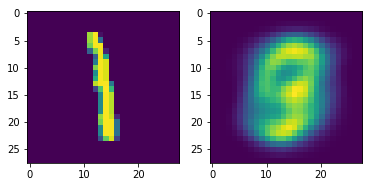

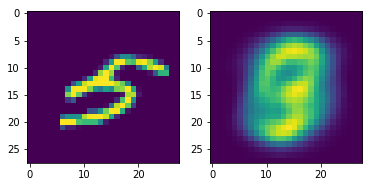

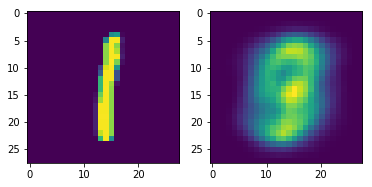

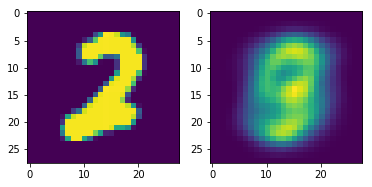

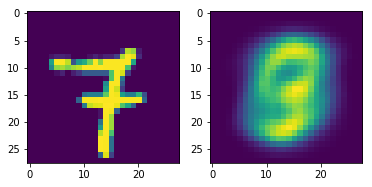

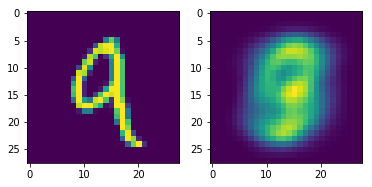

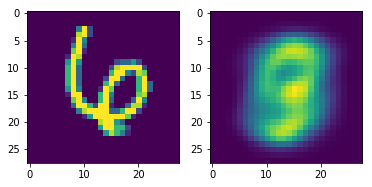

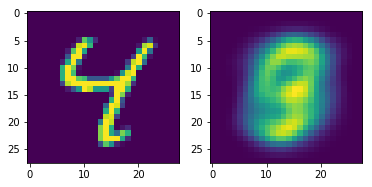

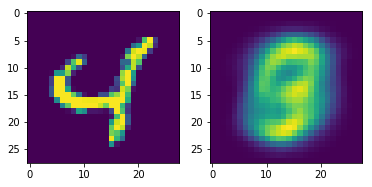

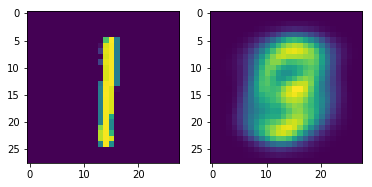

In [14]:
# Time to see the result
%matplotlib inline
num_show = 10
image_indices = np.random.randint(0, 200, num_show)
for show in range(num_show):
    x = np.reshape(mnist.test.images[image_indices[show]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (28,28))
    plt.subplot(121)
    plt.imshow(x_image)
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)